# Implementation of SELUs & Dropout-SELUs in NumPy
This looks pretty neat. 
They can prove that when you slightly modify the ELU activation,
your average unit activation goes towards zero mean/unit variance (if the network is deep enough). 
If they're right, this might make batch norm obsolete, which would be a huge bon to training speeds! 

The experiments look convincing, so apparently it even beats BN+ReLU in accuracy... though 

I wish they would've shown the resulting distributions of activations after training. 

But assuming their fixed point proof is true, it will. 

Still, still would've been nice if they'd shown it -- maybe they ran out of space in their appendix ;)

Weirdly, the exact ELU modification they proposed isn't stated explicitly in the paper! 

For those wondering, it can be found in the available sourcecode, and looks like this:

In [1]:
# An extra explaination from Reddit
# # Thanks, I will double check the analytical solution. For the numerical one, could you please explain why running the following code results in a value close to 1 rather than 0?
# du = 0.001
# u_old = np.mean(selu(np.random.normal(0,    1, 100000000)))
# u_new = np.mean(selu(np.random.normal(0+du, 1, 100000000)))
# # print (u_new-u_old) / du
# print(u_old, u_new)
# # Now I see your problem: 
# #     You do not consider the effect of the weights. 
# #     From one layer to the next, we have two influences: 
# #         (1) multiplication with weights and 
# #         (2) applying the SELU. 
# #         (1) has a centering and symmetrising effect (draws mean towards zero) and 
# #         (2) has a variance stabilizing effect (draws variance towards 1). 

# #         That is why we use the variables \mu&\omega and \nu&\tau to analyze the both effects.
# # Oh yes, thats true, zero mean weights completely kill the mean. Thanks!

# Tensorflow implementation
import numpy as np

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * np.where(x>=0.0, x, alpha * (np.exp(x)-1))

In [4]:
# """"""""""""""""""""""""""""""""""""""Dropout to a value with rescaling."""""""""""""""""""""""""""""""""""""""
# NumPy implementation
def dropout_selu(X, p_dropout):
    alpha= -1.7580993408473766 
    fixedPointMean=0.0 
    fixedPointVar=1.0
    keep_prob = 1.0 - p_dropout
#     noise_shape = noise_shape.reshape(X)
    random_tensor = keep_prob
    #         random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
    random_tensor += np.random.uniform(size=X.shape) # low=0, high=1
    #         binary_tensor = math_ops.floor(random_tensor)
    binary_tensor = np.floor(random_tensor)
    ret = X * binary_tensor + alpha * (1-binary_tensor)

    #         a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))
    a = np.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * ((alpha-fixedPointMean)**2) + fixedPointVar)))

    b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
    ret = a * ret + b
    #         ret.set_shape(x.get_shape())
    ret = ret.reshape(X.shape)
    return ret

In [5]:
# EDIT: For the fun of it, I ran a quick experiment to see if activations would really stay close to 0/1:
x = np.random.normal(size=(300, 200))
for _ in range(100):
    w = np.random.normal(size=(200, 200), scale=np.sqrt(1/200))  # their initialization scheme
    x = x @ w
    x = selu(x=x)
    x = dropout_selu(X=x, p_dropout=0.10)
    mean = x.mean(axis=1)
    scale = x.std(axis=1) # standard deviation=square-root(variance)
    print(mean.min(), mean.max(), scale.min(), scale.max())

-0.232515949215 0.201513322617 0.802763520885 1.19053692947
-0.195381110282 0.184989435984 0.846554135391 1.15312184288
-0.169750479677 0.184020585089 0.868839009207 1.17784767357
-0.184747802294 0.204314843717 0.881953747704 1.14817705679
-0.173559142007 0.214993382144 0.869697505709 1.19733238563
-0.218314140406 0.153575302549 0.871022811567 1.16007902397
-0.196880702604 0.240506960534 0.871551424298 1.15280721951
-0.203353259315 0.231563327252 0.827328094891 1.15408024762
-0.239021960612 0.199924647754 0.82754723713 1.13652273408
-0.171318339118 0.215156994029 0.851170274767 1.13895782225
-0.222475401383 0.196679972211 0.860059257323 1.12800957872
-0.263418447616 0.220970175012 0.843785289986 1.12624884404
-0.1600141237 0.266364124502 0.865597368913 1.14076404983
-0.186787738 0.298280441126 0.852768499837 1.17185892129
-0.179416603353 0.167737126149 0.843941820792 1.16935114546
-0.161122758649 0.191260786253 0.860904390473 1.18575589452
-0.187044882313 0.186882059723 0.859266774227 

In [6]:
# My NumPy implemetation of Normal dropout for ReLU
def dropout_forward(X, p_dropout):
    u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
    out = X * u
    cache = u
    return out, cache

def dropout_backward(dout, cache):
    dX = dout * cache
    return dX

In [7]:
# EDIT: For the fun of it, I ran a quick experiment to see if activations would really stay close to 0/1:
x = np.random.normal(size=(300, 200))
for _ in range(100):
    w = np.random.normal(size=(200, 200), scale=np.sqrt(1/200))  # their initialization scheme
    x = x @ w
    x = selu(x)
    x, _ = dropout_forward(p_dropout=0.8, X=x)
    mean = x.mean(axis=1)
    scale = x.std(axis=1) # standard deviation=square-root(variance)
    print(mean.min(), mean.max(), scale.min(), scale.max())

-0.231921552947 0.205240271306 0.959559397803 1.30683997472
-0.232878572258 0.244668575343 0.956916861795 1.43996258687
-0.244880507301 0.400038118486 0.998917067879 1.58661165578
-0.21619381187 0.339647741092 1.06985549361 1.68672987809
-0.204633155259 0.376022587439 1.05605942671 1.76512717898
-0.157701351545 0.393720624242 1.09954887384 1.85568666575
-0.155484269348 0.466262555265 1.13862266436 1.92573697266
-0.111770021666 0.469575897379 1.21037699743 2.124692154
-0.139937132059 0.490713331488 1.1721806166 2.11632850434
-0.217489684692 0.545963625836 1.15222184507 2.09077813307
-0.238708720474 0.569139391448 1.2111838962 2.10146437294
-0.211100122885 0.439907507471 1.23846479411 2.13017176194
-0.172591422552 0.529197632632 1.29130128106 2.30888912185
-0.257952512643 0.48331127522 1.30839150688 2.18686300781
-0.140180897111 0.55930176637 1.2910108532 2.26804240326
-0.207817976177 0.637984950226 1.19657196518 2.26216848596
-0.168422932788 0.597874378031 1.27361030041 2.3057602796
-0.

In [6]:
def elu_fwd(X):
    alpha = 1.0
    scale = 1.0
    #     return scale * np.where(x>=0.0, x, alpha * (np.exp(x)-1))
    X_pos = np.maximum(0.0, X) # ReLU
    X_neg = np.minimum(X, 0.0) # otherwise: if X<=0, Exp Leaky ReLU
    X_neg_exp = alpha * (np.exp(X_neg)-1) # a: slope, a>=0
    out = scale * (X_pos + X_neg_exp)
    cache = (scale, alpha, X) # mean=0, std=1
    return out, cache

def elu_bwd(dout, cache):
    scale, alpha, X = cache # mean=0, std=1
    dout = dout * scale
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    X_neg = np.minimum(X, 0) # otherwise: if X<=0, Exp Leaky ReLU
    dX_neg = dX_neg * alpha * np.exp(X_neg) # derivative of abs(np.exp(X_neg)-1) # a: slope, a>=0
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_pos = dX_pos * 1
    dX = dX_neg + dX_pos
    return dX

In [7]:
# EDIT: For the fun of it, I ran a quick experiment to see if activations would really stay close to 0/1:
x = np.random.normal(size=(300, 200))
for _ in range(100):
    w = np.random.normal(size=(200, 200), scale=np.sqrt(1/200))  # their initialization scheme
    x = x @ w
    x, _ = elu_fwd(X=x)
    x, _ = dropout_forward(p_dropout=0.95, X=x)
    mean = x.mean(axis=1)
    scale = x.std(axis=1) # standard deviation=square-root(variance)
    print(mean.min(), mean.max(), scale.min(), scale.max())

0.0267840597416 0.34870387555 0.688048836569 1.04717887996
0.0118506955263 0.304876451832 0.56287559608 0.883068359607
-0.00848144962242 0.206902931306 0.461438275839 0.773605957189
-0.0135542733853 0.188593823674 0.382063563973 0.688186843237
-0.0561000469178 0.122238741339 0.349825172164 0.602874984924
-0.0343566384099 0.18028897461 0.31253884688 0.548510582005
-0.0429958073188 0.116054084819 0.258804537482 0.468348512243
-0.0365803448673 0.0872113156711 0.24577948731 0.438054082984
-0.0599072152755 0.107624519345 0.215066658884 0.422357677398
-0.0350411695585 0.0776162947341 0.205136251217 0.425153568286
-0.0283457218838 0.0652535851403 0.185845104457 0.385896334075
-0.0272042989458 0.0766230668132 0.17945437564 0.343158539221
-0.0265363719492 0.0529204998045 0.175905477592 0.337747682314
-0.0195131277272 0.050982043472 0.157488026364 0.320393452692
-0.0279429986826 0.0494597719809 0.148463686617 0.302291903009
-0.0163050932564 0.0395091568666 0.134573867209 0.275776177388
-0.035063

In [7]:
def selu_fwd(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    #     return scale * np.where(x>=0.0, x, alpha * (np.exp(x)-1))
    X_pos = np.maximum(0.0, X) # ReLU
    X_neg = np.minimum(X, 0.0) # otherwise: if X<=0, Exp Leaky ReLU
    X_neg_exp = alpha * (np.exp(X_neg)-1) # a: slope, a>=0
    out = scale * (X_pos + X_neg_exp)
    cache = (scale, alpha, X) # mean=0, std=1
    return out, cache

def selu_bwd(dout, cache):
    scale, alpha, X = cache # mean=0, std=1
    dout = dout * scale
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    X_neg = np.minimum(X, 0) # otherwise: if X<=0, Exp Leaky ReLU
    dX_neg = dX_neg * alpha * np.exp(X_neg) # derivative of abs(np.exp(X_neg)-1) # a: slope, a>=0
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_pos = dX_pos * 1
    dX = dX_neg + dX_pos
    return dX

# def dropout_selu_forward(X, p_dropout):
def dropout_selu_forward(X, keep_prob):
    alpha= -1.7580993408473766
    fixedPointMean=0.0
    fixedPointVar=1.0

    u = np.random.binomial(1, keep_prob, size=X.shape) / keep_prob
    out = X * u + alpha * (1-u)

    #     a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))
    a = np.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * (alpha-fixedPointMean)**2 + fixedPointVar)))
    b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
    out = a * out + b
    cache = a, u
    return out, cache

def dropout_selu_backward(dout, cache):
    a, u = cache
    dout = dout * a
    dX = dout * u
    return dX

In [14]:
# EDIT: For the fun of it, I ran a quick experiment to see if activations would really stay close to 0/1:
x = np.random.normal(size=(300, 200))
for _ in range(100):
    w = np.random.normal(size=(200, 200), scale=np.sqrt(1/200))  # their initialization scheme
    x = x @ w
    x, cache = selu_fwd(x)
    x, _ = dropout_selu_forward(keep_prob=0.95, X=x)
    mean = x.mean(axis=1)
    scale = x.std(axis=1) # standard deviation=square-root(variance)
    print(mean.min(), mean.max(), scale.min(), scale.max())

-0.115228899805 0.273307640366 0.832187931633 1.20092983661
-0.11342776269 0.297433766906 0.890738815289 1.25180513542
-0.12925098648 0.362425379672 0.93295919605 1.3384718603
-0.12964971994 0.366295910839 0.966780089222 1.40596996607
-0.0864575866013 0.290687936815 0.959321646025 1.33767307621
-0.111998627179 0.300401219852 0.951157571282 1.35759226264
-0.0878051364106 0.313732327559 0.985100281202 1.39437359224
-0.102829064867 0.313342590658 0.967987306932 1.41533396008
-0.134024418009 0.514400568221 1.0022174775 1.42117544315
-0.156572603248 0.331289658482 1.00391056547 1.41748889863
-0.164599296478 0.300678860193 0.987115048323 1.39145024166
-0.0764760393873 0.297173187184 0.996668365766 1.37470533887
-0.126296878605 0.326807280604 0.978965605922 1.37800377186
-0.0872685363087 0.326317075429 0.987838245488 1.40211446152
-0.118293785738 0.419532184593 0.958342284191 1.3946407666
-0.0860908759643 0.436037876788 0.961645016304 1.44609169824
-0.0636222554284 0.386101182923 0.9988063343

In [18]:
# EDIT: For the fun of it, I ran a quick experiment to see if activations would really stay close to 0/1:
x = np.random.normal(size=(300, 200))
for _ in range(100):
    w = np.random.normal(size=(200, 200), scale=np.sqrt(1/200))  # their initialization scheme
    x = x @ w
    x, cache = selu_fwd(x)
    x = dropout_selu(X=x, p_dropout=0.10)
    mean = x.mean(axis=1)
    scale = x.std(axis=1) # standard deviation=square-root(variance)
    print(mean.min(), mean.max(), scale.min(), scale.max())

-0.235271254088 0.218746820232 0.819007812136 1.11747800096
-0.20951946942 0.180946004293 0.834080921638 1.13113481879
-0.191676850317 0.224930764106 0.868843915156 1.13158722935
-0.176701747105 0.157517304949 0.852585573073 1.12639938655
-0.162840032431 0.186669002989 0.858098346654 1.18314823773
-0.220704901111 0.190378608271 0.833024054349 1.14342284633
-0.19923882051 0.211312399024 0.87131817578 1.121972573
-0.210321754749 0.237660213544 0.871612931827 1.11061683783
-0.185461154997 0.225793126856 0.862512256897 1.1125366835
-0.178912312266 0.155551393681 0.852681937939 1.16124534451
-0.208812346507 0.179387508362 0.84954272907 1.16233918417
-0.227677609213 0.203579291629 0.853329180904 1.13222261062
-0.177117268663 0.182170079468 0.870238280515 1.21209197618
-0.187281710031 0.206016154254 0.866706826485 1.24963262405
-0.18972440741 0.171150605527 0.839788078575 1.16848345882
-0.187734315865 0.204341560836 0.850645039618 1.14832907681
-0.280902837708 0.170151586913 0.888266070211 1.

In [19]:
alpha = 1.6732632423543772848170429916717
scale = 1.0507009873554804934193349852946
alpha_p = -scale * alpha
def alpha_dropout(h, q):
    '''h is activation, q is keep probability'''
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = mask * h + (1 - mask) * alpha_p
    a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
    b = -a * (1 - q) * alpha_p
    return a * dropped + b

def alpha_dropout_fwd(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = mask * h + (1 - mask) * alpha_p
    a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
    b = -a * (1 - q) * alpha_p
    out = a * dropped + b
    cache = (a, mask)
    return out, cache

def alpha_dropout_bwd(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

In [21]:
# EDIT: For the fun of it, I ran a quick experiment to see if activations would really stay close to 0/1:
m, s = [],  []
x = np.random.normal(size=(300, 200))
for _ in range(100):
    w = np.random.normal(size=(200, 200), scale=np.sqrt(1/200))  # their initialization scheme
    x = x @ w
    x, cache = selu_fwd(x)
#     x, _ = dropout_selu_forward(keep_prob=0.95, X=x)
#     x = alpha_dropout(h=x, q=0.50) # q=1-p_dropout
    x, _ = alpha_dropout_fwd(h=x, q=0.50) # q=1-p_dropout

    mean = x.mean(axis=1)
    scale = x.std(axis=1) # standard deviation=square-root(variance)
    print(mean.min(), mean.max(), scale.min(), scale.max())
    m.append(mean.min())
    m.append(mean.max())
    s.append(scale.min())
    s.append(scale.max())

-0.199007114117 0.21410101311 0.855145770615 1.16449884423
-0.204944545115 0.260433083588 0.850929532387 1.13018697172
-0.194858721723 0.267553115338 0.870493546678 1.1882511917
-0.190411718171 0.27603142666 0.870020570903 1.16889035186
-0.220510881496 0.229490359452 0.836665536832 1.17474248634
-0.17813117831 0.209460889676 0.858172670232 1.15229564704
-0.224311405052 0.186348789054 0.858304168055 1.14701717009
-0.211792226542 0.187050488622 0.836112208211 1.14903739752
-0.217034891796 0.180251434341 0.870487991226 1.1562581912
-0.209800576034 0.198356416401 0.82303711073 1.19071746809
-0.188236728595 0.203071041078 0.8441844066 1.16083635095
-0.184210959605 0.188898425039 0.831493764308 1.1445359585
-0.177561326557 0.23504212488 0.842434297006 1.12493499164
-0.203524030262 0.206411430994 0.852353989348 1.15152727689
-0.224523699652 0.17347198934 0.818922555399 1.13926788725
-0.182600438736 0.207087455771 0.838925695682 1.11614054063
-0.213269148288 0.242864625127 0.845390426144 1.159

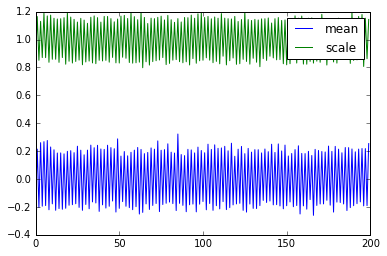

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(m, label='mean')
plt.plot(s, label='scale')
plt.legend()
plt.show()

# Discussion & wrapup
According to this, even after a 100 layers, mean neuron activations stay fairly close to mean 0 / variance 1 
(even the most extreme means/variances are only off by 0.2).

Sepp Hochreiter is amazing: LSTM, meta-learning, SNNN. 

I think he has already done a much larger contribution to science than some self-proclaimed pioneers of DL 
who spend more time on social networks than actually doing any good research.